# Photon Transfer Curve

The Photon Transfer Curve (PTC) method allows measurements of the gain (conversion factor from photoelectrons to DNs) and read noise of a detector. These parameters are essential for both the choice of the acquisition parameters and the reduction of the data.

As see in [the acquisition chain](README.md#2-the-acquisition-chain), after subtraction of the dark, the signal S measured in DN by the sensor is

S = g * [ t * E + R ]

where t is the exposure time, E is the photon-induced signal in electrons per second and R is the read noise. The photon signal follows [Poisson statistics](https://en.wikipedia.org/wiki/Poisson_distribution). Its variance in electrons is σ_e² = t * E, *i.e.* equal to the photo-electron signal itself. Expressed in DNs, it is (g * σ_e)². The variance of the read noise in DNs is (g * σ_r)². The variance of the total signal S is then

σ_s² = (g * σ_e)² + (g * σ_r)²

We can distinguish two regimes
- For faint photon signals, the variance is independent of the signal and equal to (g * σ_r)².
- For intense photon signals, the read noise is negligible and the variance is (g * σ_e)² = g² * t * E.

We see that in the shot-noise dominated regime, the variance is g * (g * t * E), *i.e.* it is proportional to the signal with slope g. We can thus measure the gain by measuring the variance at varying intensity levels and fitting a line to a graph of the variance *vs.* signal. Knowing the gain, the read noise in electrons is obtained from the mean of the variance in the read noise dominated region.

Note that usually the measurements are made by varying the intensity of the source, not the exposure time. We do not have a precise and accurate way to vary the intensity level. Instead, we assume [reciprocity](https://en.wikipedia.org/wiki/Reciprocity_(photography)) of the sensor, which is true for all practical purposes, and vary the exposure time.

## Data acquisition

We illuminate the sensor with a uniform source and take two images at each intensity level (exposure time). By taking the difference of these two images we can suppress the pixel-to-pixel variations of the response, which are identical from frame to frame. The variance in a single frame is half the variance measured in the difference, which has twice as much noise.

We will study four different gain settings: 0, 99, 100, 200. Note that this 'gain' value of 100 is *not* the gain as defined above. It is a setting value in arbitrary units, to which corresponds a true gain (as expressed in DN / electron).

Cool the camera to -5°C, so that thermal signal won't affect the results. For gain settings 0, 99, 100, use a bias of 15. For gain setting 200, use a bias of 50.

For each gain, vary the exposure time from 0s to saturation, in doubling steps, starting with a step of 0.00001s. Take two images at each exposure time and save the images in different directories for each gain setting.

## Data reduction

For each gain setting, we read all the files, identify the exposure time pairs, take their difference, compute the variance, and compute the mean signal. The calculations are limited to a subfield to limit the influence of a possible non-uniform illumination.

100%|██████████| 16/16 [00:29<00:00,  1.86s/it]


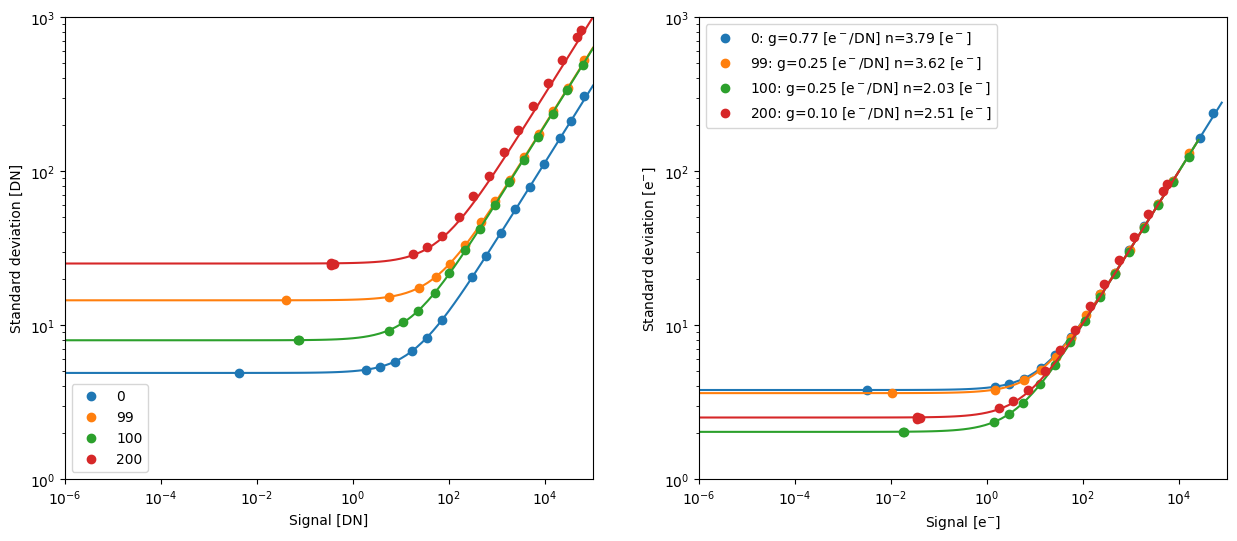

In [14]:
import os
import glob
import numpy as np
from tqdm import tqdm
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from inout import get_headers
from image import Image

def ptc_model(x, g, n):
    return np.sqrt(g * x + n ** 2)

path = r'C:\Users\fauchere\Pictures\ZWO ASI2600MM Pro\2023-07-22\PTC'

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

files = glob.glob(os.path.join(path, '**', '*.fits'), recursive=True)

bias_files = {0: r'C:\EOS6D\bias\asi2600mm_bias_iso000_t-4.800_2023-07-22.fits',
              99: r'C:\EOS6D\bias\asi2600mm_bias_iso099_t-5.300_2023-07-22.fits',
              100: r'C:\EOS6D\bias\asi2600mm_bias_iso100_t-4.900_2023-07-22.fits',
              200: r'C:\EOS6D\bias\asi2600mm_bias_iso200_t-6.000_2023-07-22.fits'}

# Limit the measurement to a small FOV in case the illumination is not uniform
fov_half_width = 100

headers = get_headers(files)
# Find the unique occurrences of ISO (gain) values in the headers
gain_key = 'ISO' if 'ISO' in headers[0] else 'GAIN'
unique_gains = list(set([h[gain_key] for h in headers]))  # set is used to remove duplicates
gain_ptc = []
for gain in unique_gains:
    bias_frame = fits.getdata(bias_files[gain])
    fov = tuple([slice(s // 2 - fov_half_width, s // 2 + fov_half_width) for s in bias_frame.shape])
    # Find the unique occurrences of EXPTIME (exposure time) values in the headers for the given ISO
    unique_exposure_times = list(set([h['EXPTIME'] for h in headers if h[gain_key] == gain]))
    signal = []  # signal will be stored here
    std = []  # standard deviation will be stored here
    for t in tqdm(unique_exposure_times):
        # Finds the files matching the current ISO and EXPTIME
        matching_files = [f for h, f in zip(headers, files) if h['EXPTIME'] == t and h[gain_key] == gain]
        if len(matching_files) > 1:
            # Read in the data and subtract the bias frame
            image1 = Image(matching_files[0]).data - bias_frame
            image2 = Image(matching_files[1]).data - bias_frame
            # Compute the mean of each bias-subtracted frame
            mean1 = np.mean(image1[fov])
            mean2 = np.mean(image2[fov])
            # Signal is the mean signal in the two frames
            signal.append((mean1 + mean2) / 2)
            # The noise is the standard deviation of the difference.
            # Division by 2 takes into account the fact that the noise is doubled due to the subtraction of 2 images
            std.append(np.sqrt( np.mean( ( (image1 - mean1) - (image2 - mean2) ) ** 2 ) / 2 ))
    signal = np.array(signal)
    std = np.array(std)
    # Fits the standard deviation as a function of the signal withe a model
    p, _ = curve_fit(ptc_model, signal, std, p0=[1, 10], bounds=([0, 0], [10, 1000]), sigma=std ** 2)

    gain_ptc.append({'signal': signal, 'std': std, 'gain': p[0], 'read_noise': p[1]})

x_lim = 1e-3, 1e5

# For plotting the model
dn_scale = 10 ** (np.log10(x_lim[0]) + np.linspace(0, np.log10(x_lim[1]) - np.log10(x_lim[0]), 100))

for ax, units, gain_norm in zip(axes.flatten(), ['DN', 'e$^{-}$'], [False, True]):
    for ptc, gain in zip(gain_ptc, unique_gains):
        norm = ptc['gain'] if gain_norm else 1
        if gain_norm:
            label = f'{gain:d}: g={1 / ptc["gain"]:.2f} [e$^-$/DN] n={ptc["read_noise"] / norm:.2f} [e$^-$]'
        else:
            label = f'{gain:d}'
        p = ax.plot(ptc['signal'] / norm, ptc['std'] / norm, 'o', label=label)
        ax.plot(dn_scale / norm, ptc_model(dn_scale, ptc['gain'], ptc['read_noise']) / norm, color=p[0].get_color())

    ax.set_xlabel(f'Signal [{units}]')
    ax.set_ylabel(f'Standard deviation [{units}]')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(*x_lim)
    ax.set_ylim(1, 1e3)
    ax.legend()

(0.0, 4.0)

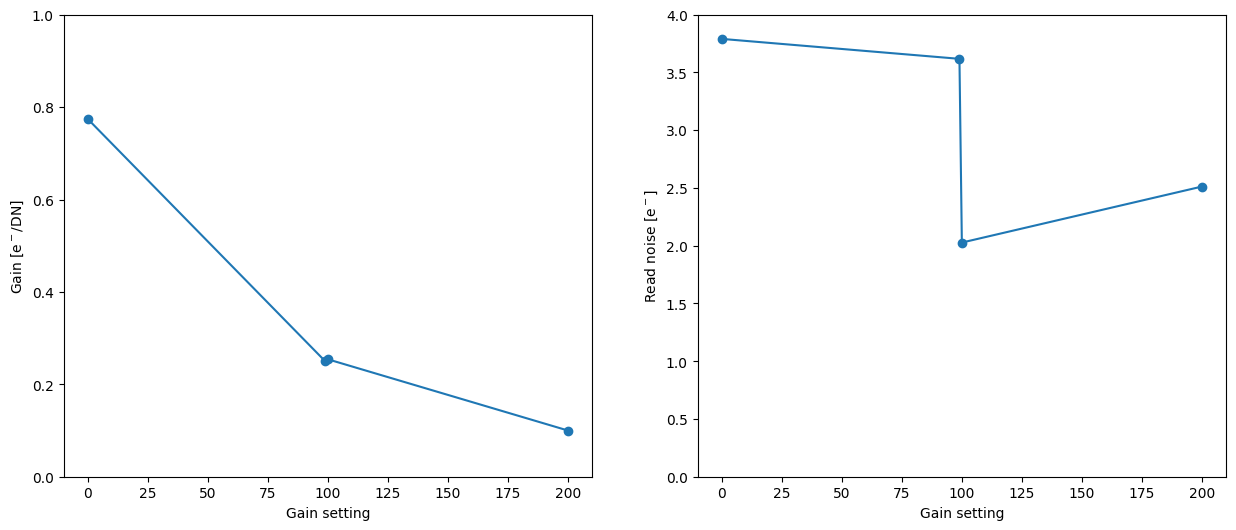

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
g = [1 / ptc['gain'] for ptc in gain_ptc]
n = [ptc['read_noise'] / ptc['gain'] for ptc in gain_ptc]
axes[0].plot(unique_gains, g, 'o-')
axes[0].set_xlabel('Gain setting')
axes[0].set_ylabel('Gain [e$^-$/DN]')
axes[0].set_ylim(0, 1)
axes[1].plot(unique_gains, n, 'o-')
axes[1].set_xlabel('Gain setting')
axes[1].set_ylabel('Read noise [e$^-$]')
axes[1].set_ylim(0, 4)
